In [1]:
from prelim import do_prelim_on_single_feature
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
import numpy as np
from matplotlib import pyplot as plt
import itertools
import requests

In [3]:
uri = "localhost:27017"
client = MongoClient(uri, server_api=ServerApi('1'))

db = client.test
historical_evolution_data = db.historicalEvolutionData
problem_instances = db.probleminstances
db_prelim_information = db.prelimInformation

## Set up important parameters

PILOT projection, borders, ...

Prior to the usage of this juypter notebook --> it is necessary to initialize and save the prelim data of the dataset

```http
   POST http://localhost:8080/localsearch/init
   Content-Type: application/json
   {
    "experimentId": "27-09-1000",
    "transposedProjectionMatrix" : [
        [-0.3960,-0.3227],
        [0.1701,-0.6613],
        [0.4294,-0.7562],
        [-0.3783,-0.1508],
        [0.7470,0.3224]
    ],
    "featureNames" : ["totalPassengerCount", "passengerRatio","totalCongestion","blockedPassengerRatio", "conflictFreePassengerSeatingRatio"]
    }
   ```

In [4]:
experiment_id = "27-09-1000"

transformed_projection_matrix_values = {
        "totalPassengerCount":[-0.3960,-0.3227],
        "passengerRatio":[0.1701,-0.6613],
        "totalCongestion":[0.4294,-0.7562],
        "blockedPassengerRatio":[-0.3783,-0.1508],
        "conflictFreePassengerSeatingRatio":[0.7470,0.3224]
}

x_plot_lim = [-5, 4]
y_plot_lim = [-6, 5]

likely_border = [
[-0.930918238683993,-3.98302995127808],
[1.53689913375061,-2.91803891677161],
[3.71308700286112,-1.14492369879520],
[2.97512568832687,1.72424892180437],
[1.51713523168341,4.29180389059854],
[0.0614017557687737,3.71158833360980],
[-2.40641561666583,2.64659729910332],
[-4.58260348577634,0.873482081126921],
[-3.84464217124209,-1.99569053947265],
[-2.38665171459863,-4.56324550826682],
[-0.930918238683993,-3.98302995127808],
]

generator_colors = {
    "SimpleGenerator" : "darkorange",
    "RealisticGenerator" : "blue",
    "LocalSearchController" : "green"
}

#necessary because of inconsistencies of generator naming
generators_alt_names = {
    "SimpleGenerator" : "mk_s",
    "RealisticGenerator" : "mk_r",
    "LocalSearchController" : "lokalesuche"
}

sorted_feature_names = sorted(transformed_projection_matrix_values.keys())
transformed_projection_matrix = []
for i in range(0, len(sorted_feature_names)):
    transformed_projection_matrix.append(transformed_projection_matrix_values[sorted_feature_names[i]])

projection_matrix = np.array(transformed_projection_matrix).transpose()

In [5]:
def get_instances_and_coordinates():
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    instances = problem_instances.find({"experimentId" : experiment_id})
    instance_feature_vectors = list(map(lambda x: (x, convert_instance_to_feature_vector(x, prelim_information[0])), instances))
    return list(map(lambda x: (x[0], convert_feature_vector_to_coordinates(x[1])), instance_feature_vectors))

def convert_instance_to_feature_vector(instance, prelim_data):
    feature_vector = {}
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        feature_vector[feature] = do_prelim_on_single_feature(instance["featureDescription"][feature], prelim_data["prelimDataOfFeatures"][feature])
    return feature_vector

def convert_feature_vector_to_coordinates(feature_vector):
    sorted_features= sorted(feature_vector.keys())
    vector_array = []
    for i in range(0, len(sorted_features)):
        vector_array.append(feature_vector[sorted_features[i]])
    vector = np.array(vector_array)
    return np.matmul(projection_matrix, vector)

def create_border_coordinates(border_values):
    prelim_information = db_prelim_information.find({"experimentId" : experiment_id})
    prelim_data = prelim_information[0]
    for feature in prelim_data["prelimDataOfFeatures"].keys():
        for border_point in border_values:
            border_point[feature] = do_prelim_on_single_feature(border_point[feature], prelim_data["prelimDataOfFeatures"][feature])
    return list(map(lambda x: convert_feature_vector_to_coordinates(x), border_values))


def base_instance_space(instance_coordinate_pairs, border_coords = [], original_instances_more_transparent = False, targets = []):
        instance_coordinate_pairs.sort(key = lambda x: x[0]["featureDescription"]["source"])
        grouped_instances_by_source = itertools.groupby(instance_coordinate_pairs, key= lambda x: x[0]["featureDescription"]["source"])
        for key, group in grouped_instances_by_source:
            alpha = 1.0
            if (original_instances_more_transparent and (key == "SimpleGenerator" or key == "RealisticGenerator")):
                alpha = 0.3
            group_list = list(group)
            x_coords = [pair[1][0] for pair in group_list]
            y_coords = [pair[1][1] for pair in group_list]
            plt.scatter(x_coords, y_coords, label=generators_alt_names[key], color=generator_colors[key], alpha = alpha, s = 1.6, zorder=2)

        if (len(border_coords) > 0):
            xs, ys = zip(*border_coords)
            plt.plot(xs, ys, color='red',zorder=1)

        if (len(targets) > 0):
            xs, ys = zip(*targets)
            plt.scatter(xs, ys, color='black', s = 3, marker='o', label="Zielpunkt")
    
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.10),ncol=4)
        ax = plt.gca()
        ax.set_axisbelow(True)
        plt.grid()
        plt.title("Instanzraum")
        plt.xlim(x_plot_lim)
        plt.xticks(np.arange(min(x_plot_lim), max(x_plot_lim), 1.0))
        plt.ylim(y_plot_lim)
        plt.yticks(np.arange(min(y_plot_lim), max(y_plot_lim), 1.0))

        plt.xlabel("$\mathregular{Z_1}$")
        plt.ylabel("$\mathregular{Z_2}$")
    
        return plt

## Plot the current instance space and color the different generators

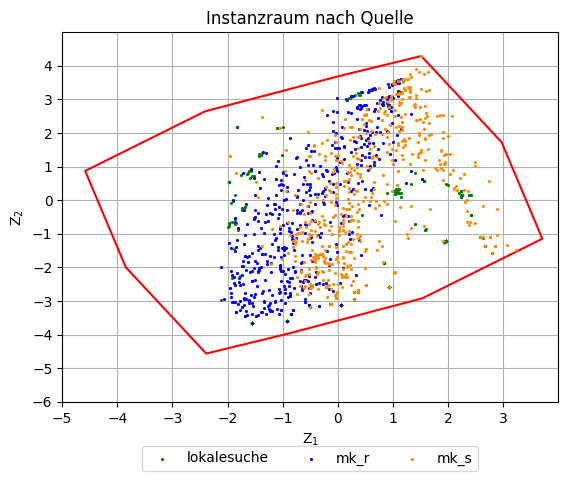

In [7]:
instances_and_coordinates = get_instances_and_coordinates()
plt = base_instance_space(instances_and_coordinates, border_coords = likely_border)
plt.title("Instanzraum nach Quelle")
plt.show()

## Use local search to evolve new instances

Code below shows the necessary call. If you don't want prior local search experiments to pollute your data then a deletion is necessary

Mutation types:
- "AddPassengerMutation"
- "RemovePassengerMutation"
- "IncreaseAvgRouteLengthMutation"

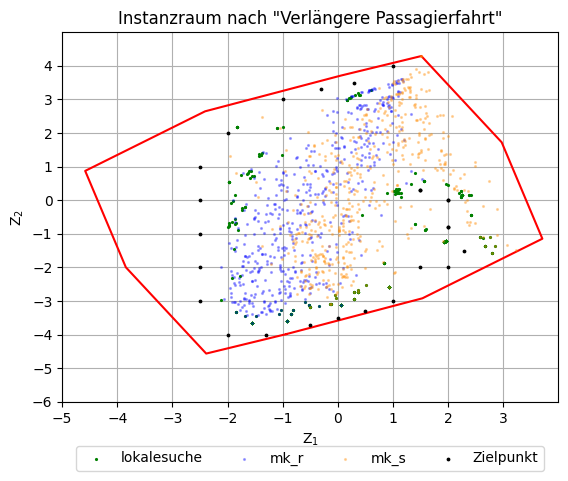

In [68]:
def post_local_search_generation(target_x, target_y, mutation_name, local_search_rounds, iterations):
    url = 'http://localhost:8080/localsearch/generate'
    data = {
        "experimentId": experiment_id,
        "transposedProjectionMatrix" : list(transformed_projection_matrix_values.values()),
        "featureNames" : list(transformed_projection_matrix_values.keys()),
        "targetX" : target_x,
        "targetY" : target_y,
        "mutationName" : mutation_name,
        "iterations" : iterations,
        "localSearchRounds" : local_search_rounds
    }

    requests.post(url, json=data)

def local_search(target_points, mutation_type, local_search_rounds, iterations):
    for point in target_points:
        post_local_search_generation(point[0], point[1], mutation_type, local_search_rounds, iterations)   

target_points = [
    [1.5, 0.3],
    [2.0, 0],
    [2, -0.8],
    [2.3, -1.5],
    [2, -2],
    [1.5, -2],
    #on border
    [1, -3],
    [0.5, -3.3],
    [0, -3.5],
    [-0.5, -3.7],
    [-1.3, -4],
    [-2, -4],
    [-2.5, -3],
    [-2.5, -2],
    [-2.5, -1],
    [-2.5, 0],
    [-2.5, 1],

    #decrease
    [-2,2],
    [-1,3],
    [-0.3,3.3],
    [0.3,3.5],
    [1,4],
    [1.5, 0.3],
    [2.0, 0],
    [2, -0.8],
]

# Delete prior data
problem_instances.delete_many({"experimentId" : experiment_id, "source" : "LocalSearchController"})
# Call backend to use local search
local_search(target_points, "IncreaseAvgRouteLengthMutation", 3, 20)  

# Visualize results
instances_and_coordinates = get_instances_and_coordinates()
plt = base_instance_space(instances_and_coordinates, border_coords = likely_border, targets = target_points, original_instances_more_transparent = True)
plt.title("Instanzraum nach \"Verlängere Passagierfahrt\"")
plt.show()